# <font color="#8333ff">Projet_10 : Détectez des faux billets avec Python</font>

 # <font color="#8333ff">1- Importation de données

On charge tout d'abord les librairies nécessaires

In [161]:
# On importe les librairies dont on aura besoin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from scipy import stats

On importe ensuite les données :

In [162]:
billets = pd.read_csv('billets.csv',sep=';')

billets = pd.get_dummies(billets, columns = ['is_genuine'], drop_first = True) # On remplace les strings par 0 et 1
billets.describe()
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   diagonal         1500 non-null   float64
 1   height_left      1500 non-null   float64
 2   height_right     1500 non-null   float64
 3   margin_low       1463 non-null   float64
 4   margin_up        1500 non-null   float64
 5   length           1500 non-null   float64
 6   is_genuine_True  1500 non-null   uint8  
dtypes: float64(6), uint8(1)
memory usage: 71.9 KB


 # <font color="#8333ff"> 2- Préparation des données :</font> 

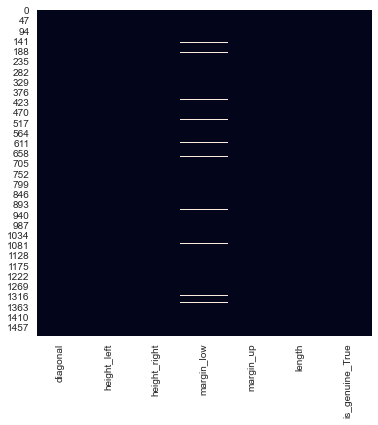

In [163]:
plt.figure(figsize=(6,6)) #Carte chaleur des NaN

sns.heatmap(billets.isna(),cbar=False)
plt.show()

# <font color="#8333ff"> 3- Imputation par regression linéaire multiple pour les NaN de la variable margin_low :

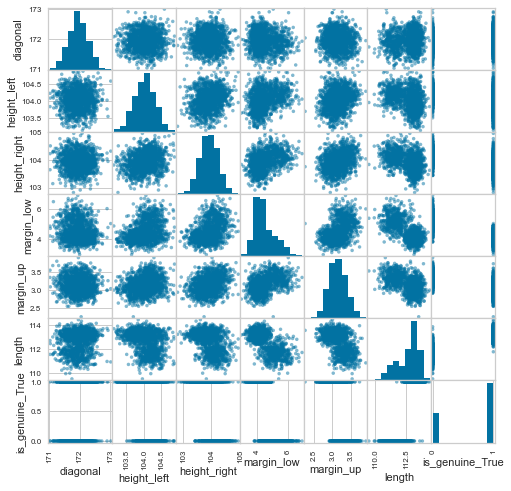

In [165]:
# Vérifier s'il y'a des variables corrélées avec margin_low et s'il y'a des points atypiques
# Voir la distribution empirique

pd.plotting.scatter_matrix(billets, figsize = (8,8)) # Graphique croisant toutes les variables
plt.show()

# La symétrie des variables (y'a pas des points qui se démarque pour toutes les variables)

Voir la distribution de la variable margin_low avant l'imputation :

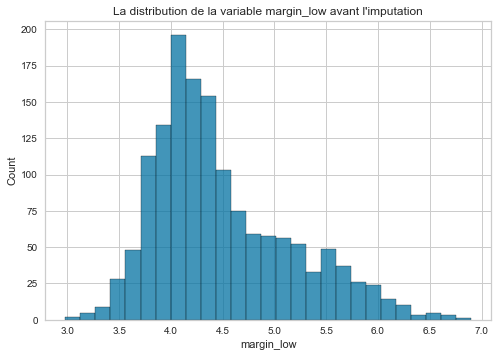

In [166]:
sns.histplot(billets['margin_low'])
plt.title("La distribution de la variable margin_low avant l'imputation")
plt.show()

On donne le nom billets_LR (pour regression linéaire)

In [167]:
# Définir notre variables dépendantes YVar et indépendantes XVar

# Données d'entrainement: On utilise les lignes ou on a pas des NaN pour entrainer notre model

billets_LR = billets[billets.margin_low.notnull()] # Données d'entrainement

XVar = billets_LR.drop('margin_low', axis = 1) # Variables explicatives
YVar = billets_LR[['margin_low']] # Variable cible

billets_LR.shape


(1463, 7)

In [168]:
# Création de notre modele linéaire : moindres carrés ordinaires

reg__line_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length+is_genuine_True', data = billets_LR).fit()

print(reg__line_multi.summary())

#Le test est globalement significatif à 5% (F-statistic<0.05)

#R carré = 62% (c'est à dire que 62% de la variabilité de margin_low est expliqué par le model)

#R*2 :est un indicateur utilisé en statistiques pour juger de la qualité d’une régression linéaire

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          4.75e-299
Time:                        12:45:11   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.8668      8.316     

# On retire les variables non significatives

On va donc maintenant retirer les variables non significatives.
On commence par la moins significative : lenght, car elle a une p-valeur de 0.87

In [169]:
reg__line_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+is_genuine_True', data = billets_LR).fit()
print(reg__line_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     469.2
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          2.12e-300
Time:                        12:45:13   Log-Likelihood:                -774.15
No. Observations:                1463   AIC:                             1560.
Df Residuals:                    1457   BIC:                             1592.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.4247      7.873     

On constate qu'il faut maintenant retirer la variable diagonal :

In [170]:
reg__line_multi = smf.ols('margin_low~height_left+height_right+margin_up+is_genuine_True', data = billets_LR).fit()
print(reg__line_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     586.8
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          8.76e-302
Time:                        12:45:14   Log-Likelihood:                -774.21
No. Observations:                1463   AIC:                             1558.
Df Residuals:                    1458   BIC:                             1585.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3902      5.476     

On constate qu'il faut maintenant retirer la variable height_left :

In [171]:
reg__line_multi = smf.ols('margin_low~height_right+margin_up+is_genuine_True', data = billets_LR).fit()
print(reg__line_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     782.5
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          3.69e-303
Time:                        12:45:18   Log-Likelihood:                -774.46
No. Observations:                1463   AIC:                             1557.
Df Residuals:                    1459   BIC:                             1578.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.0446      3.960     

On constate qu'il faut maintenant retirer la variable height_right :

In [172]:
reg__line_multi = smf.ols('margin_low~margin_up+is_genuine_True', data = billets_LR).fit()
print(reg__line_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          1.24e-304
Time:                        12:45:19   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.9263      0.198     

# Prévision des valeurs de la variables cible (margin_low) :

On remarque qu'à présent, tous les paramètres sont significatifs. Quant au R*2, il vaut environ 0.62, tout comme le R*2 ajusté.

*On peut donc utiliser ce modèle à des fins de prévision !*

Si l'on souhaite prévoir la valeur de margin_low pour imputer nos NaN on saisit les lignes suivantes :

In [173]:
A_prevoir = billets[billets.margin_low.isnull()].loc[:,['margin_up','is_genuine_True']] # les valeurs à imputées

margin_low_prev = reg__line_multi.predict(A_prevoir) #prévoir nos NaN

billets.margin_low.fillna(margin_low_prev, inplace = True) # Remplacer les NaN par les valeurs imputées
billets.head(75)

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine_True
0,171.81,104.86,104.95,4.520000,2.89,112.83,1
1,171.46,103.36,103.66,3.770000,2.99,113.09,1
2,172.69,104.48,103.50,4.400000,2.94,113.16,1
3,171.36,103.91,103.94,3.620000,3.01,113.51,1
4,171.73,104.28,103.46,4.040000,3.48,112.54,1
...,...,...,...,...,...,...,...
70,171.81,103.84,103.66,4.350000,2.93,112.97,1
71,171.84,103.59,103.98,4.090000,3.05,113.09,1
72,171.94,103.89,103.45,4.074248,3.25,112.79,1
73,171.35,103.58,103.59,4.080000,2.85,114.09,1


Exemple pour prévoir margin_low pour la  ligne 72 :

In [174]:
a_prevoir = pd.DataFrame({'margin_up': 3.25, 'is_genuine_True': 1}, index=[0])
margin_low_prev = reg__line_multi.predict(a_prevoir)
print(round(margin_low_prev[0], 2))
margin_low_prev

4.07


0    4.074248
dtype: float64

# Vérifier la colinéarité des variables :
Vérifier l'éventuelle colinéarité approchée des variables :

In [175]:
variables = reg__line_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5938854494007748, 1.5938854494007753]

Tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

# Testez l’homoscédasticité :

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [176]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg__line_multi.resid, variables)
print('p value test Breusch Pagan:', pval, f_pval)


p value test Breusch Pagan: 3.2033559115838186e-36 2.74562835936448e-38


p-valeur est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

f_pval est presque égale à 0 : Donc on admet que le niveau d'heterogénieté est faible.

# Testez la normalité des résidus :

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

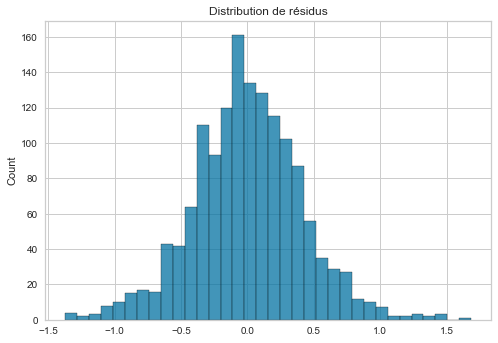

In [177]:
sns.histplot(reg__line_multi.resid)
plt.title('Distribution de résidus')
plt.show()

Les résidus ne sont pas très différents d'une distribution symétrique

In [178]:
shapiro(reg__line_multi.resid)

ShapiroResult(statistic=0.9936248064041138, pvalue=6.20942773821298e-06)

H0 : résidus normales (résidu gaussien)

Ici, l'hypothèse de normalité est remise en cause (p-value = 6.20942773821298e-06 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.

Maintenant nous voyons la distribution de la variable margin_low aprés l'imputation :
On remarque que c'est la meme distribution pour la variable avant et aprés.

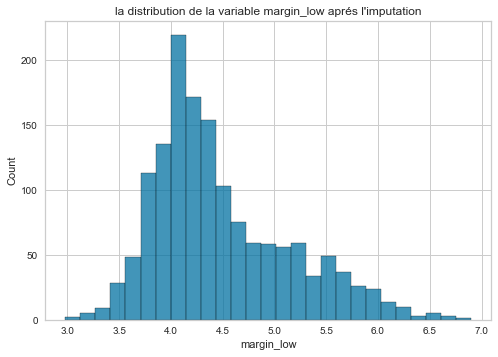

In [179]:

sns.histplot(billets['margin_low'])
plt.title("la distribution de la variable margin_low aprés l'imputation")
plt.show()

# <font color="#8333ff">4- Visualisez le nuage de points :

Voir l'aspet de répartions des individus en utilisant 2 variables :

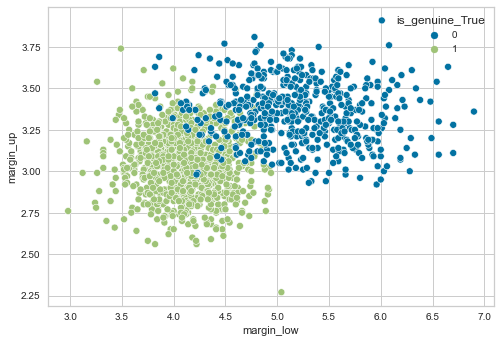

In [180]:
# On affiche le nuage de points dont on dispose :

sns.scatterplot(data = billets, x='margin_low', y = 'margin_up',hue = 'is_genuine_True' )

plt.show()

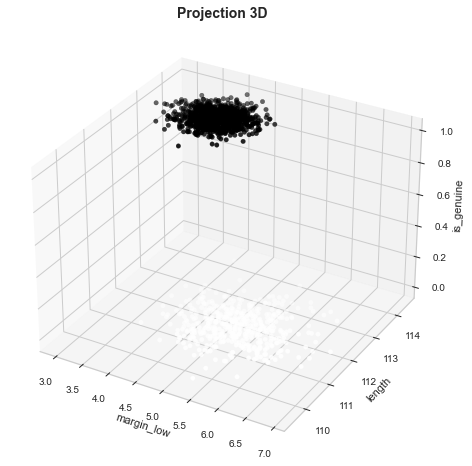

In [181]:
# Graphe nuage des points en 3D :

plt.figure(figsize=(8,8))
axes = plt.axes(projection = '3d')
axes.set_title("Projection 3D ",fontsize=14,fontweight="bold")
axes.scatter(ys=billets.length, xs=billets.margin_low, zs=billets.is_genuine_True, c=billets.is_genuine_True)
axes.set_xlabel('margin_low')
axes.set_ylabel('length')
axes.set_zlabel('is_genuine')
plt.savefig("Graphe nuage des points.png" , dpi = 300, bbox_inches = 'tight') # Enregistrement du figure dans le répertoire de travail et augmentation de la résolution
plt.show()

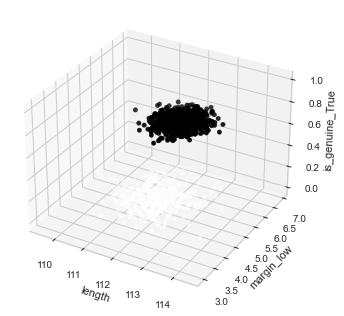

In [182]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = billets['length']
y = billets['margin_low']
z = billets['is_genuine_True']

ax.set_xlabel("length")
ax.set_ylabel("margin_low")
ax.set_zlabel("is_genuine_True")

ax.scatter(x, y, z, c=z)

plt.show()

# <font color="#8333ff">5 - Régression logistique :

Pour prévoir les valeurs de is_genuine_True en d'autre terme si le billet est faux ou vrai :

In [183]:
# Définir notre variables dépendantes y et indépendantes x (les données d'entrainement) :

x_LR = billets.drop('is_genuine_True', axis = 1) # Var indépendants
y_LR = billets[['is_genuine_True']] # Target
x_LR.shape

(1500, 6)

In [184]:
# Diviser le dataset entre training/testing set :

x_train,x_test,y_train,y_test = train_test_split(x_LR, y_LR, test_size=0.2, random_state=0, stratify = billets.is_genuine_True)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(1200, 6)
(300, 6)
(1200, 1)
(300, 1)


In [185]:
# Centrage et Réduction de données :

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train

array([[-0.90635892,  2.12942537, -0.63276278,  1.16758385,  0.30014711,
        -1.55756554],
       [ 1.75819322,  1.00335861,  0.33679513, -0.322423  , -0.35069591,
         0.03019409],
       [-0.28134052, -0.98381804, -0.69336015, -0.65691433, -0.22052731,
         0.31576236],
       ...,
       [-1.9919172 , -1.08317687, -1.48112594, -1.18905964,  0.30014711,
         0.68128976],
       [-0.70898469, -1.01693765, -1.20843778, -0.83936415, -1.65238195,
         0.46425787],
       [-1.07083745,  0.90399977, -0.20858119,  1.45646273,  0.47370524,
        -0.9178926 ]])

In [186]:
# Construction du model :

Log_reg = LogisticRegression(random_state = 0, solver = 'liblinear')
Log_reg.fit(x_train, y_train.values.ravel())

LogisticRegression(random_state=0, solver='liblinear')

In [187]:
print(Log_reg.intercept_) # Affichage de l'intercept

print(Log_reg.coef_) # Affichage des coeficients

A = pd.DataFrame(Log_reg.coef_[0], index = x_LR.columns, columns = ['Coef'] ) # Pour mieux afficher les résultats

A

[1.74512909]
[[ 0.24025889 -0.3602486  -0.72866873 -2.78774699 -1.52429307  3.36582461]]


,Coef
diagonal,0.240259
height_left,-0.360249
height_right,-0.728669
margin_low,-2.787747
margin_up,-1.524293
length,3.365825


In [188]:
print(A.sort_values(by = 'Coef' , ascending = False)) # Pour voir l'importance des variables

                  Coef
length        3.365825
diagonal      0.240259
height_left  -0.360249
height_right -0.728669
margin_up    -1.524293
margin_low   -2.787747


In [189]:
print(A.sort_values(by = 'Coef' , ascending = False, key = lambda v:abs(v))) # Trier les variables selon la valeur absolue de coefficient
# Les 2 variables les plus importants variables sont length et margin_low

                  Coef
length        3.365825
margin_low   -2.787747
margin_up    -1.524293
height_right -0.728669
height_left  -0.360249
diagonal      0.240259


In [190]:
# Faire des prédictions :

y_pred = Log_reg.predict(x_test)

print(y_pred)
print(y_test)
y_test.shape

[1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1
 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1
 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1
 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1
 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1
 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1
 1 1 1 0]
      is_genuine_True
347                 1
451                 1
1028                0
677                 1
690                 1
...               ...
325                 1
507                 1
664                 1
415                 1
1472                0

[300 rows x 1 columns]


(300, 1)

In [191]:
print(np.unique(y_pred, return_counts = True)) # On a 300 échantillons dont 100 des faux billets et 200 des vrais

(array([0, 1], dtype=uint8), array([100, 200], dtype=int64))


In [192]:
# Evaluation du model :

print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred)) # Taux d'erreur est de 1 % (100 - accuracy)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       100
           1       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

0.9933333333333333


In [193]:
# Matrice de confusion:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
print(cm)

#Tp = 99, Fp = 1, Fn = 1, Tn = 199

[[ 99   1]
 [  1 199]]


In [194]:
# Tester le model avec des données extérieures (exemple: billets_production) :

billets_production = pd.read_csv('billets_production.csv')
print([billets_production.iloc[0,:-1]])
print(billets_production)
billets_production

[diagonal        171.76
height_left     104.01
height_right    103.54
margin_low        5.21
margin_up          3.3
length          111.42
Name: 0, dtype: object]
   diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5


,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [195]:
# Automatisation du test :

for i in range (len(billets_production)):
    x_predict = sc.transform([billets_production.iloc[i,:-1]])
    if Log_reg.predict(x_predict)[0] == 1:
        print("Le billet {} ".format(billets_production.loc[i,'id']),"est un vrai billet")
    elif Log_reg.predict(x_predict)[0] == 0:
        print("Le billet {} ".format(billets_production.loc[i,'id']),"est un faux billet")

Le billet A_1  est un faux billet
Le billet A_2  est un faux billet
Le billet A_3  est un faux billet
Le billet A_4  est un vrai billet
Le billet A_5  est un vrai billet


# <font color="#8333ff">6- K-means:

In [196]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,7))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,8))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(5,7))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

# <font color="#8333ff">Analyse en Composantes Principales (ACP):


In [233]:
# Choix du nombre de composantes à calculer :

n_comp = 2

# selection des colonnes à prendre en compte dans l'ACP :

data_pca = billets[['diagonal','height_left','height_right','margin_low','margin_up','length' ]]
data_pca

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28
1496,172.19,104.63,104.44,5.27,3.37,110.97
1497,171.80,104.01,104.12,5.51,3.36,111.95
1498,172.06,104.28,104.06,5.17,3.46,112.25


In [234]:
from sklearn.decomposition import PCA

# Préparation des données pour l'ACP :

X = data_pca.values
names = billets.index
features = data_pca.columns

# Calcul des composantes principales
pca = PCA(n_components = n_comp)
pca.fit(X)

PCA(n_components=2)

In [235]:
from sklearn import preprocessing

# Centrage et Réduction :

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

print(np.std(X_scaled,axis=0)) # vérification moyennes nulles et les écarts-type unitaires

print(np.mean(X_scaled,axis=0))

[1. 1. 1. 1. 1. 1.]
[-7.85054984e-14  4.81274280e-14 -2.78343274e-14 -6.44225414e-16
 -9.85285927e-16  4.54747351e-16]


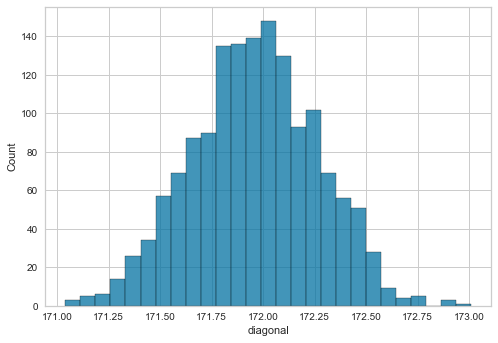

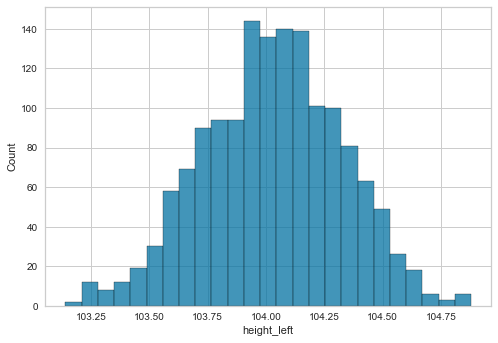

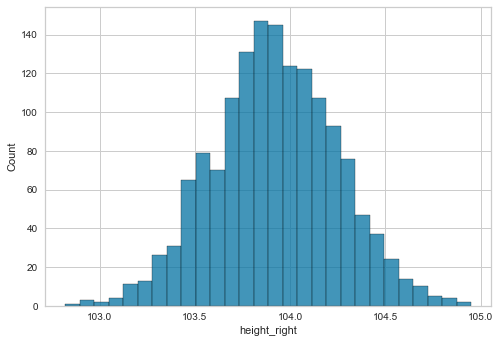

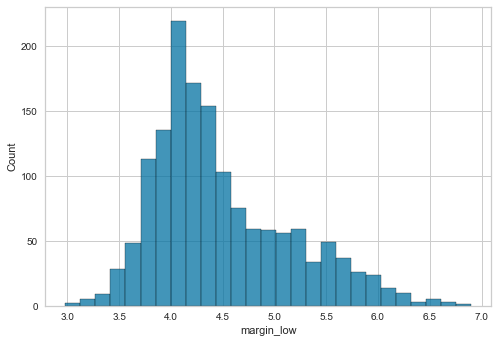

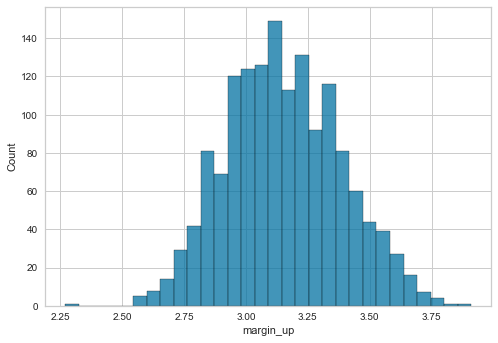

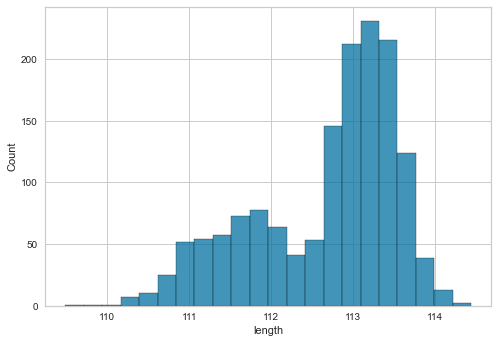

In [200]:
# Vérifions la standardisation de données:

X = pd.DataFrame(data = X) #convertir X en dataframe
X.columns = data_pca.columns
for col in X.columns:
    plt.figure()
    sns.histplot(X[col])
    plt.show()

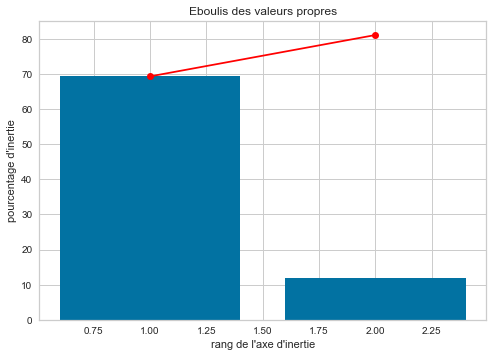

In [236]:
# Eboulis des valeurs propres

display_scree_plot(pca)


<Figure size 360x360 with 0 Axes>

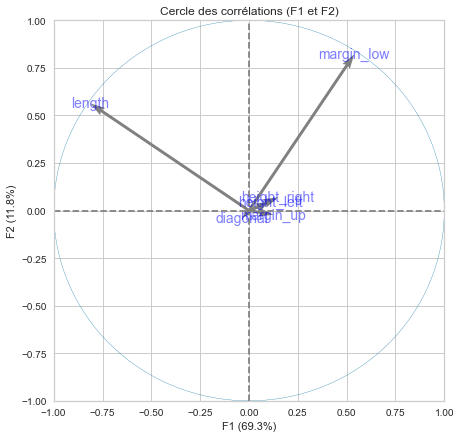

In [237]:
# Cercle des corrélations :
fig = plt.figure(figsize = (5,5))
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))
plt.show()

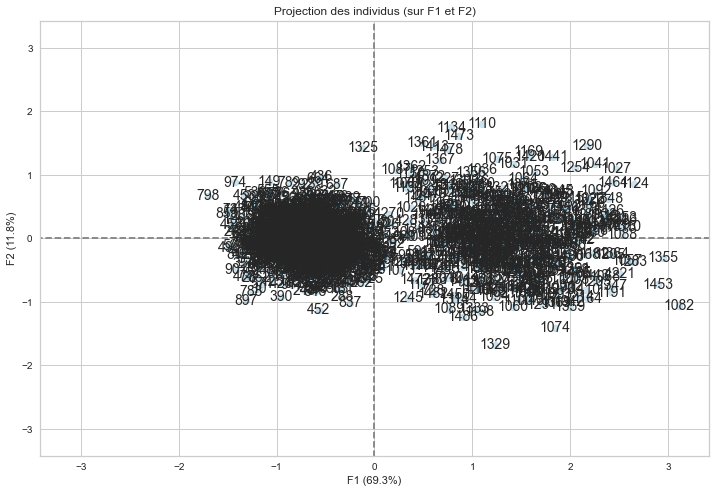

In [238]:
# Projection des individus :

X_projected = pca.transform(X)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], alpha = 0.2, labels = np.array(names))
plt.show()

On applique la méthode de coude pour se rassurer q'on a bien deux groupes d'individus :

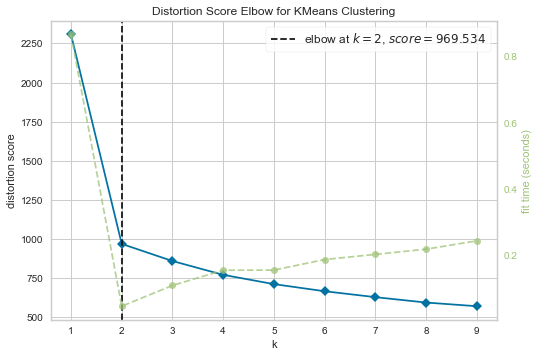

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [204]:
from yellowbrick.cluster import KElbowVisualizer
K_means = KMeans()
visualizer = KElbowVisualizer(K_means, k=(1,10)).fit(X)
visualizer.show()

In [243]:
# Projection des individus sur le 1er plan factoriel :

Kmeans = KMeans(n_clusters = 2) # Construction du model
model = Kmeans.fit(X)
#sns.scatterplot(x=X_projected[:,0], y=X_projected[:,1], hue = model.labels_) # Graphe nuage des points
#plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
#plt.show()

In [244]:
model

KMeans(n_clusters=2)

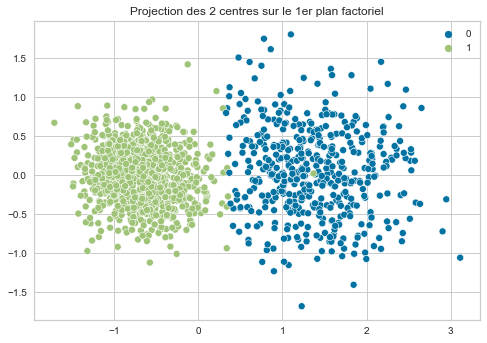

In [245]:
# Affichage des positions des centres de classes (les centroïdes) :

#X_projected1 = pca.transform(X)
clusters = model.labels_
plt.figure()
centroids = model.cluster_centers_
centroids_projected = pca.transform(centroids)
#plt.scatter(X_projected[:,0], X_projected[:,1], c = clusters)#Graphe nuage des points
#plt.scatter(centroids_projected[:,0],centroids_projected[:,1], c = 'red',s=150 ,marker = '*', label = 'centroïdes') #Centroides
sns.scatterplot(x=X_projected[:,0], y=X_projected[:,1], hue = clusters)#Graphe nuage des points
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1]) #Centroides
plt.title("Projection des {} centres sur le 1er plan factoriel".format(len(centroids)))
plt.legend()
plt.show()

In [246]:
centroids_projected

array([[ 1.36981282,  0.03144121],
       [-0.65056007, -0.01493226]])

In [250]:
# Rajouter la variable au dataframe initiale :
B = X.copy()
B['labels'] = clusters
sns.pairplot(B,hue = 'labels') # Les variables qui ont plus d'impact sur la séparabilité des clusters (fonctions des densité conditionelles)
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [210]:
# Centrage et Réduction de l'echantillon test :

billets_production1 = billets_production[['diagonal','height_left','height_right','margin_low','margin_up','length' ]]

std_scale_prod = preprocessing.StandardScaler().fit(billets_production1)
X_scaled_prod = std_scale_prod.transform(billets_production1)
X_scaled_prod = pd.DataFrame(data = X_scaled_prod)
X_scaled_prod.columns = billets_production1.columns
X_scaled_prod

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.664228,-0.502224,-1.228900,0.438224,0.485681,-1.124014
1,-0.287604,-0.050787,0.449459,1.493702,0.564017,-0.289103
2,0.157497,1.106022,0.904607,0.144293,1.190702,-0.937094
3,1.835186,1.021377,1.046841,-0.590533,-1.629382,1.094107
4,-1.040852,-1.574388,-1.172007,-1.485686,-0.611018,1.256104


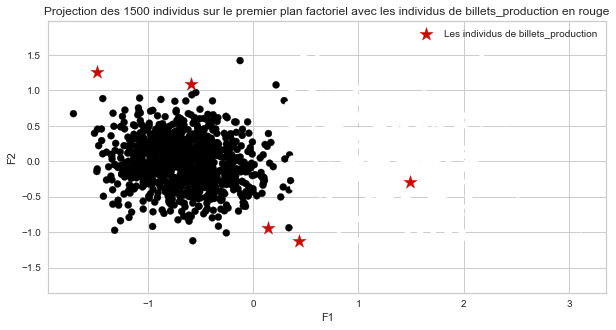

In [211]:
fig = plt.figure(figsize=(10,5))
plt.title("Projection des {} individus sur le premier plan factoriel avec les individus de billets_production en rouge".format(X_projected.shape[0]))
#kmeans = KMeans(n_clusters = 2).fit(X_scaled) # 2 clusters

plt.scatter(X_projected[:,0], X_projected[:,1], c = clusters) # Graphe nuage des points
plt.scatter(X_scaled_prod['margin_low'],X_scaled_prod['length'], c = 'r',s=200,marker = '*',label = 'Les individus de billets_production') # Graphe nuage des points
plt.xlabel('F1')
plt.ylabel('F2')
plt.legend()
plt.show()

In [212]:
X.shape

(1500, 6)

In [247]:
# Evaluation du model :


y_predic = model.predict(x_test)

print(classification_report(y_test,y_predic))

print(accuracy_score(y_test,y_predic))


              precision    recall  f1-score   support

           0       0.33      1.00      0.50       100
           1       0.00      0.00      0.00       200

    accuracy                           0.33       300
   macro avg       0.17      0.50      0.25       300
weighted avg       0.11      0.33      0.17       300

0.3333333333333333


C:\Users\narje\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [248]:
# Matrice de confusion:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_predic)

print(cm)


[[100   0]
 [200   0]]


In [249]:
# Automatisation du test :

for i in range (len(billets_production)):
    x_predict = sc.transform([billets_production.iloc[i,:-1]])
    if model.predict(x_predict)[0] == 1:
        print("Le billet {} ".format(billets_production.loc[i,'id']),"est un vrai billet")
    elif model.predict(x_predict)[0] == 0:
        print("Le billet {} ".format(billets_production.loc[i,'id']),"est un faux billet")

Le billet A_1  est un faux billet
Le billet A_2  est un faux billet
Le billet A_3  est un faux billet
Le billet A_4  est un faux billet
Le billet A_5  est un faux billet
